In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%cd ..

/home/naomichi/repos/src/github.com/agatan/ocr-experiments


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from ocr.preprocessing.generator import CSVGenerator
from ocr.models import resnet50, bboxnet, mobilenet

In [8]:
tf.keras.backend.set_session(tf.InteractiveSession())
backbone, features_pixel = mobilenet.backbone(input_shape=(512, 832, 3))
training_model = bboxnet.create_model(backbone, features_pixel, input_shape=(512, 832, 3))
tf.keras.backend.get_session().run(tf.global_variables_initializer())
training_model.load_weights('./checkpoint-weights.h5')
prediction_model = bboxnet.create_prediction_model(training_model, features_pixel)
# prediction_model.get_weights()

/home/naomichi/repos/src/github.com/agatan/ocr-experiments/venv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [9]:
gen = CSVGenerator('./data/processed/validation/annotations.csv', features_pixel=features_pixel, input_size=(512, 832))

In [10]:
images, gts = next(gen.batches(batch_size=16))
gt_scores = gts[..., 0]
gt_boxes = tf.keras.backend.get_session().run(bboxnet._reconstruct_boxes(gts[..., 1:5], features_pixel=features_pixel))
gt_angles = gts[..., 5]
training_model.predict(images)
scores, boxes, angles = prediction_model.predict(images)

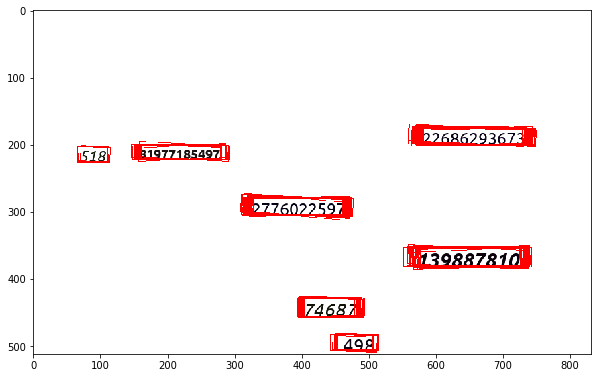

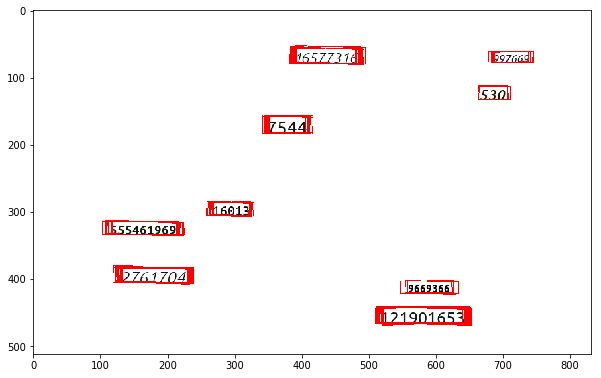

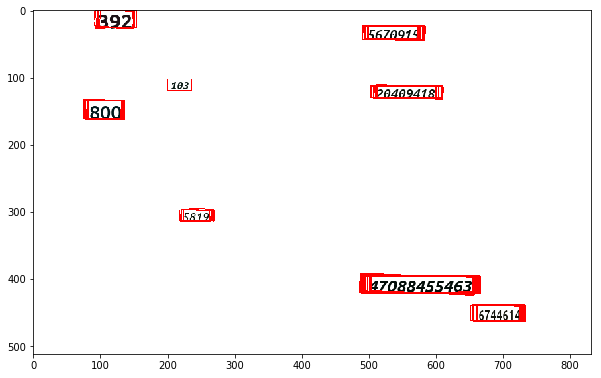

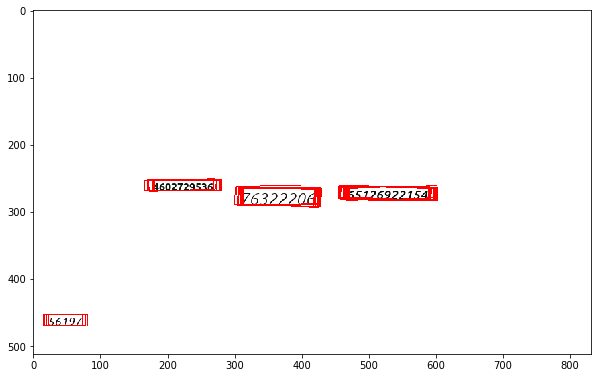

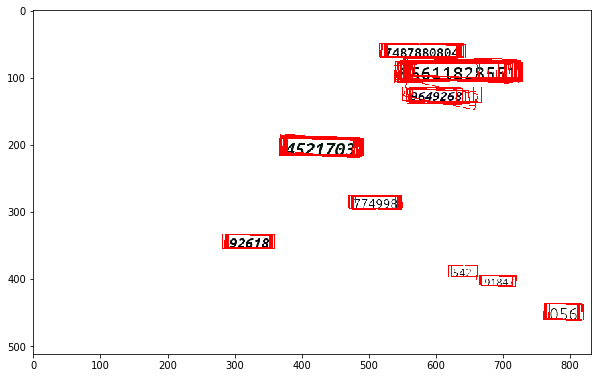

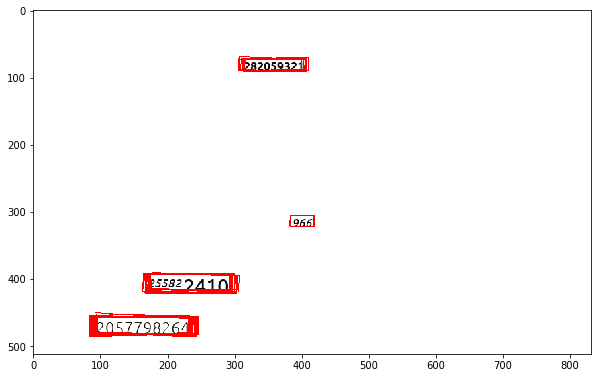

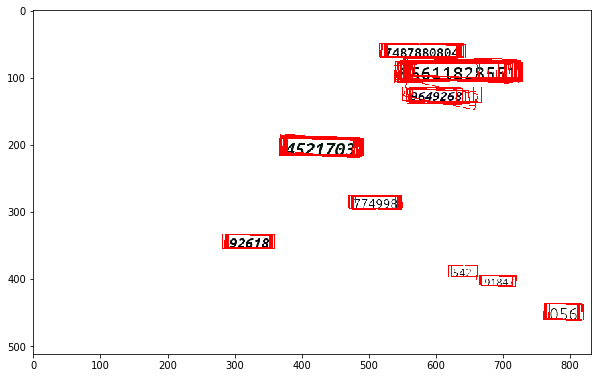

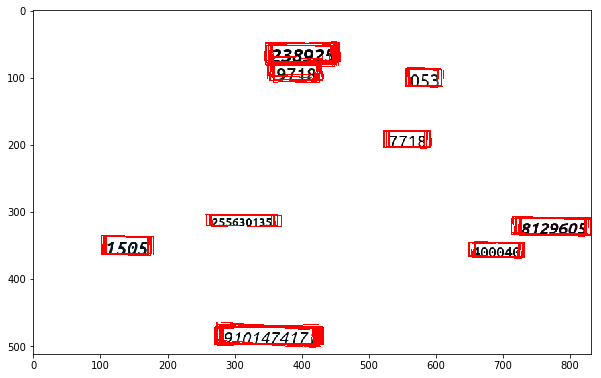

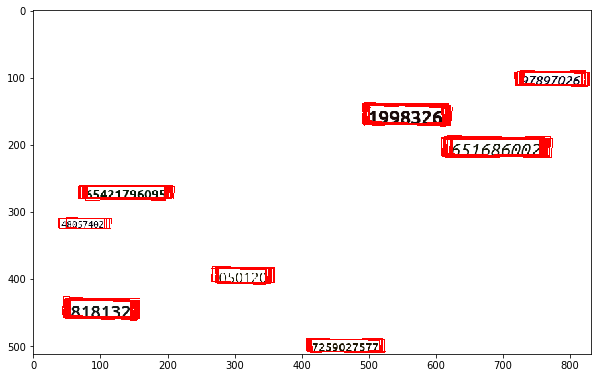

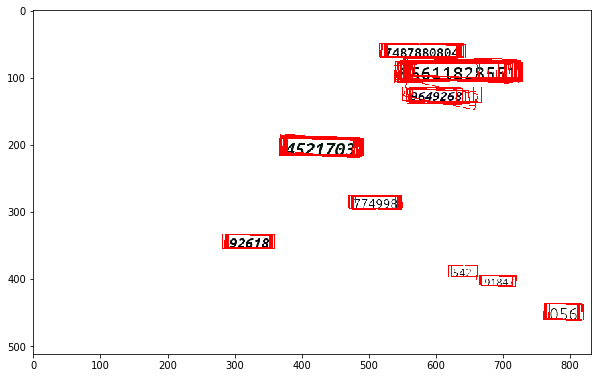

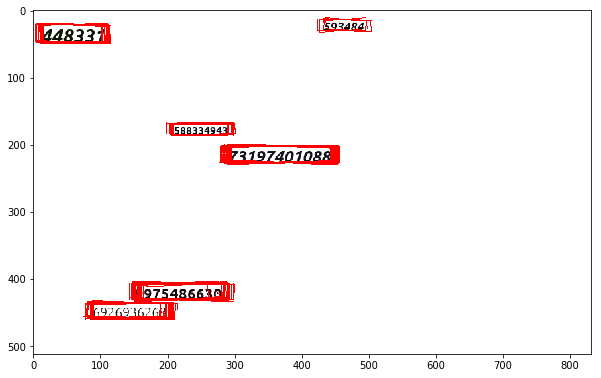

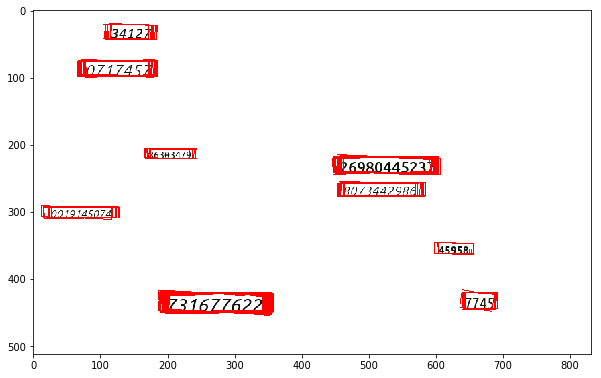

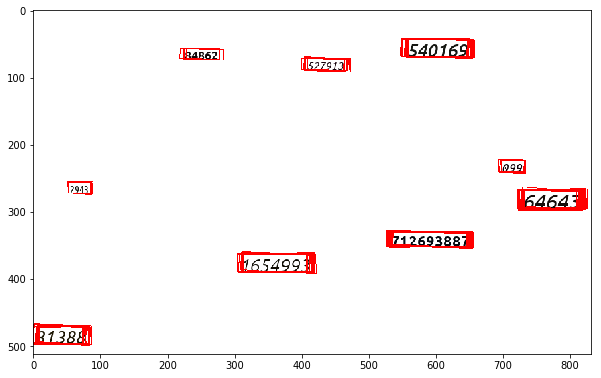

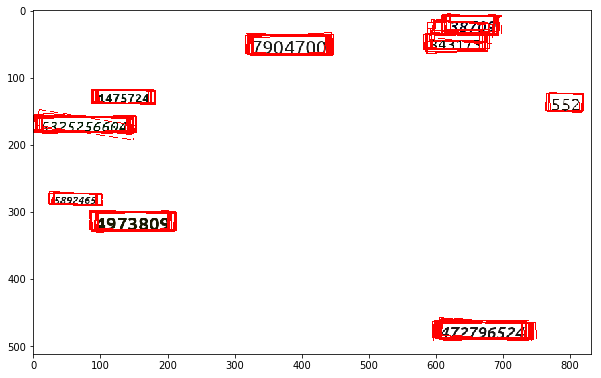

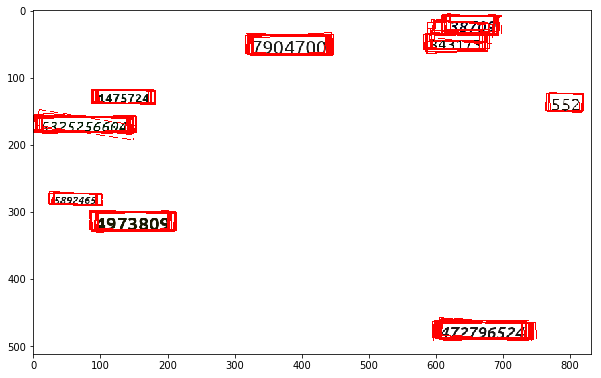

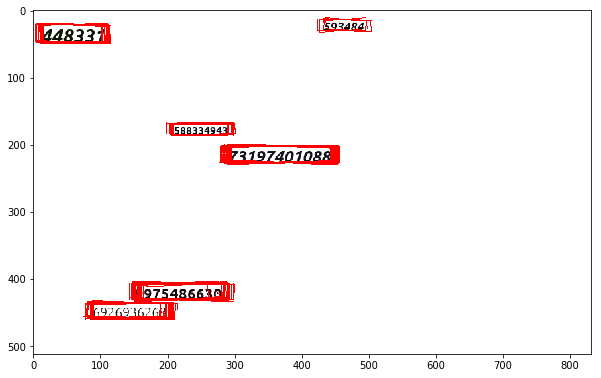

In [14]:
import random
import cv2
import math
import numpy as np

for i in range(len(images)):
    i_scores, i_boxes, i_angles = bboxnet.extract_boxes(scores[i], boxes[i], angles[i], thres=0.5)
    target = (images[i].copy() * 255).astype(np.int32)
    for (l, t, r, b), angle in zip(i_boxes, i_angles):
        theta = -angle * 90 / 180 * math.pi
        rot = np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
        cx = (l + r) / 2
        cy = (t + b) / 2
        c1 = rot.dot(np.array([l - cx, t - cy])) + np.array([cx, cy])
        c2 = rot.dot(np.array([l - cx, b - cy])) + np.array([cx, cy])
        c3 = rot.dot(np.array([r - cx, b - cy])) + np.array([cx, cy])
        c4 = rot.dot(np.array([r - cx, t - cy])) + np.array([cx, cy])
        points = np.array([c1, c2, c3, c4, c1]).astype(np.int32)
        for (p1, p2) in zip(points[:5], points[1:]):
            cv2.line(target, (p1[0], p1[1]), (p2[0], p2[1]), (255, 0, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(target)
    plt.show()